#Method 1

In [1]:
pip install numpy==1.23.5 scipy==1.9.3 scikit-learn==1.1.3 joblib==1.2.0 librosa==0.9.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 31.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
import numpy as np
import librosa
from pathlib import Path
from scipy.signal import butter, sosfiltfilt

# --------------------- CONFIG ---------------------
DATA_DIR = "/content/drive/MyDrive/COOP_Project/tester_data/all_tester"
PATTERNS = {
    0: "mast_2025*.wav",
    1: "elevator_*.wav",
    2: "gripper_*.wav",
    3: "shuttle_*.wav",
    4: "environment_*.wav",
    5: "mast_bearing_broken_*.wav",
}
SR, N_MFCC = 22050, 13
BP_LO, BP_HI = 400.0, 4000.0
EMA_ALPHA, MIN_VAR = 0.05, 1e-3
ENVIRONMENT_CLASS = 4
EPS = 1e-6

# MFCC params (ทำให้สเถียร/ deterministic)
N_FFT = 1024
HOP = 256
WIN = "hann"
CENTER = False

# --------------------- DSP ---------------------
def pre_emphasis(x, coeff=0.87):
    x = np.asarray(x, dtype=np.float32)
    if x.size == 0:
        return x
    y = np.empty_like(x)
    y[0] = x[0]
    y[1:] = x[1:] - coeff * x[:-1]
    return y

def _bp_sos(sr, lo, hi, order=4):
    nyq = 0.5 * sr
    lo_n, hi_n = max(1.0, lo) / nyq, min(hi, nyq - 1.0) / nyq
    if not (0.0 < lo_n < hi_n < 1.0):
        raise ValueError(f"Invalid band ({lo}, {hi}) for sr={sr}")
    return butter(order, [lo_n, hi_n], btype="band", output="sos")

def bandpass(x, sr, lo=BP_LO, hi=BP_HI):
    x = np.asarray(x, dtype=np.float32)
    if x.size < max(256, 3 * 4 * 2):  # กันกรณีสั้นมาก ๆ
        return x
    return sosfiltfilt(_bp_sos(sr, lo, hi), x)

def trim_and_rms_normalize(y, sr, top_db=30, target_rms=0.03):
    """ตัดช่วงเงียบ แล้ว normalize RMS → ลดผลของระดับเสียงที่ต่างกัน/คลิป"""
    if y.size == 0:
        return y
    # ตัดเงียบหลายช่วงรวมกัน
    intervals = librosa.effects.split(y, top_db=top_db)
    if intervals.size == 0:
        return np.zeros(0, dtype=np.float32)
    y_cat = np.concatenate([y[s:e] for s, e in intervals]).astype(np.float32)
    # RMS normalize แบบปลอดภัย
    rms = np.sqrt(np.mean(y_cat**2) + 1e-12)
    y_out = y_cat * (target_rms / max(rms, 1e-6))
    # clip กันหลุดขอบหลัง normalize
    y_out = np.clip(y_out, -1.0, 1.0).astype(np.float32)
    return y_out

# --------------------- Env-Warmed EMA-CMVN ---------------------
class EnvWarmedCMVN:
    def __init__(self, alpha=EMA_ALPHA, min_var=MIN_VAR):
        self.alpha = float(alpha)
        self.min_var = float(min_var)
        self.mu = None
        self.var = None
        self.ready = False

    def warmup(self, mfcc_list):
        mfcc_list = [m for m in mfcc_list if m.ndim == 2 and m.size > 0]
        if not mfcc_list:
            return False
        env = np.concatenate(mfcc_list, axis=1).astype(np.float32)
        # กัน NaN/Inf
        env = np.nan_to_num(env, nan=0.0, posinf=0.0, neginf=0.0)
        self.mu = env.mean(axis=1).astype(np.float32)
        self.var = np.maximum(env.var(axis=1), self.min_var).astype(np.float32)
        self.ready = True
        return True

    def normalize(self, M):
        M = np.nan_to_num(M, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
        if not self.ready:
            W = min(10, M.shape[1])
            self.mu = M[:, :W].mean(axis=1).astype(np.float32)
            self.var = np.maximum(M[:, :W].var(axis=1), self.min_var).astype(np.float32)
            self.ready = True
        mu = self.mu.copy()
        var = self.var.copy()
        out = np.empty_like(M, dtype=np.float32)
        a = self.alpha
        for t in range(M.shape[1]):
            x = M[:, t]
            d = x - mu
            mu = mu + a * d
            # EW variance (numerically stable)
            var = (1.0 - a) * (var + a * (d * d))
            var = np.maximum(var, self.min_var)
            out[:, t] = (x - mu) / np.sqrt(var + EPS)
        # เก็บสถานะล่าสุด (optional: คงค่าไว้สำหรับสตรีม)
        self.mu, self.var = mu, var
        return out

# --------------------- Feature Extraction (EMA-CMVN only) ---------------------
def compute_mfcc(x, sr):
    """ห่อ librosa.feature.mfcc ด้วยพารามิเตอร์คงที่ + กัน NaN"""
    mfcc = librosa.feature.mfcc(
        y=x, sr=sr, n_mfcc=N_MFCC,
    ).astype(np.float32)
    return np.nan_to_num(mfcc, nan=0.0, posinf=0.0, neginf=0.0)

def features_from_signal(y, sr, env_norm: EnvWarmedCMVN):
    # 1) ตัดเงียบ + RMS normalize
    y = trim_and_rms_normalize(y, sr)
    if y.size < int(0.1 * sr):  # น้อยกว่า 0.1s ข้าม
        return None
    # 2) pre-emphasis + band-pass
    x = bandpass(pre_emphasis(y), sr)
    # 3) MFCC แล้วค่อย EMA-CMVN
    mfcc = compute_mfcc(x, sr)
    if mfcc.size == 0:
        return None
    M = env_norm.normalize(mfcc)
    # 4) time-pooling robust + กันค่าพิเศษ
    q25 = np.percentile(M, 25, axis=1)
    q75 = np.percentile(M, 75, axis=1)
    feat = np.concatenate([
        M.mean(axis=1),
    ]).astype(np.float32)
    feat = np.nan_to_num(feat, nan=0.0, posinf=0.0, neginf=0.0)
    return feat  # shape = (4 * N_MFCC,)

# --------------------- Build Dataset (single directory) ---------------------
def build_dataset(base_dir: str | Path, patterns: dict[int, str]):
    """
    Build dataset using Env-Warmed EMA-CMVN (preprocess ที่เข้มขึ้น):
    1) ตัดเงียบ + RMS normalize
    2) pre-emphasis + band-pass
    3) MFCC (พารามิเตอร์คงที่) → EMA-CMVN (อุ่นด้วย environment)
    4) สรุปฟีเจอร์แบบ robust (mean/std/percentile)
    """
    base_dir = Path(base_dir)
    env_norm = EnvWarmedCMVN()

    # --- Warmup จาก environment_* ---
    env_mfcc = []
    for p in sorted(base_dir.glob(patterns[ENVIRONMENT_CLASS])):
        try:
            y, _ = librosa.load(p, sr=SR, mono=True, res_type="kaiser_fast")
            y = trim_and_rms_normalize(y, SR)
            if y.size < SR * 0.1:
                continue
            x = bandpass(pre_emphasis(y), SR)
            env_mfcc.append(compute_mfcc(x, SR))
        except Exception as e:
            print(f"[WARN] env skip {p}: {e}")
    if not env_norm.warmup(env_mfcc):
        print("[WARN] No env warmup data; will init from first frames on first clip.")

    # --- Extract ทุกคลาส ---
    X, ys, groups = [], [], []
    for label, pattern in patterns.items():
        for p in sorted(base_dir.glob(pattern)):
            try:
                y, _ = librosa.load(p, sr=SR, mono=True, res_type="kaiser_fast")
                feat = features_from_signal(y, SR, env_norm)
                if feat is None:
                    continue
                if not np.all(np.isfinite(feat)):
                    continue
                X.append(feat); ys.append(label); groups.append(p.stem)
            except Exception as e:
                print(f"[WARN] skip {p}: {e}")

    if not X:
        return (np.empty((0, 4 * N_MFCC), dtype=np.float32),
                np.asarray([], dtype=int),
                np.asarray([], dtype=str))
    return np.vstack(X), np.asarray(ys, dtype=int), np.asarray(groups, dtype=str)

# --------------------- Minimal demo ---------------------


##Train

In [ ]:
if __name__ == "__main__":
    X, y, groups = build_dataset(DATA_DIR, PATTERNS)
    print("X:", X.shape, "| y:", y.shape, "| groups:", groups.shape)
    if y.size:
        u, c = np.unique(y, return_counts=True)
        print("class counts:", " ".join(f"{int(k)}:{int(v)}" for k, v in zip(u, c)))


In [ ]:
# --------------------- t-SNE Process ---------------------
X, y, groups_tsne = X, y, groups
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=132)
X_embedded = tsne.fit_transform(X)

print("Plotting t-SNE results...")
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.title('t-SNE of Audio Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
legend = plt.legend(*scatter.legend_elements(), title="Classes")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np

# Assuming X and y are already loaded from the t-SNE section

# Split data into training and testing sets
X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(
    X, y, test_size=0.2, random_state=132, stratify=y # Use stratification to maintain class proportions
)

# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
scaler_tsne = StandardScaler()
X_train_tsne_scaled = scaler_tsne.fit_transform(X_train_tsne)
X_test_tsne_scaled = scaler_tsne.transform(X_test_tsne)

# Train model
logreg_model_tsne = LogisticRegression(class_weight="balanced", max_iter=2000)
logreg_model_tsne.fit(X_train_tsne_scaled, y_train_tsne)

# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test_tsne, preds_logreg_tsne))

# --- LightGBM (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training LightGBM (t-SNE features) ---")
lgb_train_tsne = lgb.Dataset(X_train_tsne, y_train_tsne)
lgb_test_tsne = lgb.Dataset(X_test_tsne, y_test_tsne, reference=lgb_train_tsne)

params_tsne = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train_tsne)), # Dynamically set num_class
    'verbose': -1,
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
}

gbm_tsne = lgb.train(params_tsne, lgb_train_tsne, valid_sets=[lgb_test_tsne], num_boost_round=100)
preds_lgb_proba_tsne = gbm_tsne.predict(X_test_tsne, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test_tsne, preds_lgb_tsne))

##Test

In [ ]:
if __name__ == "__main__":
    X_test, y_test, groups = build_dataset("/content/drive/MyDrive/COOP_Project/tester_data/RPB3", PATTERNS)
    print("X:", X.shape, "| y:", y.shape, "| groups:", groups.shape)
    if y.size:
        u, c = np.unique(y, return_counts=True)
        print("class counts:", " ".join(f"{int(k)}:{int(v)}" for k, v in zip(u, c)))


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np

# Assuming X and y are already loaded from the t-SNE section


# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
X_test_tsne_scaled = scaler_tsne.transform(X_test)


# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test, preds_logreg_tsne))


preds_lgb_proba_tsne = gbm_tsne.predict(X_test, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test, preds_lgb_tsne))

In [ ]:
if __name__ == "__main__":
    X_test, y_test, groups = build_dataset("/content/drive/MyDrive/COOP_Project/tester_data/RP06", PATTERNS)
    print("X:", X.shape, "| y:", y.shape, "| groups:", groups.shape)
    if y.size:
        u, c = np.unique(y, return_counts=True)
        print("class counts:", " ".join(f"{int(k)}:{int(v)}" for k, v in zip(u, c)))


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np

# Assuming X and y are already loaded from the t-SNE section


# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
X_test_tsne_scaled = scaler_tsne.transform(X_test)


# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test, preds_logreg_tsne))


preds_lgb_proba_tsne = gbm_tsne.predict(X_test, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test, preds_lgb_tsne))

In [ ]:
if __name__ == "__main__":
    X_test, y_test, groups = build_dataset("/content/drive/MyDrive/COOP_Project/tester_data/RP54", PATTERNS)
    print("X:", X.shape, "| y:", y.shape, "| groups:", groups.shape)
    if y.size:
        u, c = np.unique(y, return_counts=True)
        print("class counts:", " ".join(f"{int(k)}:{int(v)}" for k, v in zip(u, c)))


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np

# Assuming X and y are already loaded from the t-SNE section


# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
X_test_tsne_scaled = scaler_tsne.transform(X_test)


# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test, preds_logreg_tsne))


preds_lgb_proba_tsne = gbm_tsne.predict(X_test, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test, preds_lgb_tsne))

#Method 2 83/88/90

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
import warnings
warnings.filterwarnings('ignore')

# === Configuration ===
DATA_DIR = "/content/drive/MyDrive/COOP_Project/tester_data/all_tester"   # Training folder
TEST_DIR = "/content/drive/MyDrive/COOP_Project/tester_data/RPB3"         # Test folder
OUTPUT_TRAIN = "/content/drive/MyDrive/COOP_Project/train_features_improved.csv"
OUTPUT_TEST = "/content/drive/MyDrive/COOP_Project/test_features_improved.csv"

PATTERNS = {
    0: "mast_2025*.wav",
    1: "elevator_*.wav",
    2: "gripper_*.wav",
    3: "shuttle_*.wav",
    4: "environment_*.wav",
    5: "mast_bearing_broken_*.wav",
}

# Feature extraction parameters
SAMPLE_RATE = 22050
DURATION = 2
N_MFCC = 13



# === Updated Feature Names (must match extracted features) ===
feature_names = []

# MFCCs: mean and std
for i in range(N_MFCC):
    feature_names += [f'mfcc_{i}_mean', f'mfcc_{i}_std']


# === Improved Feature Extraction Function ===
def extract_features(file_path):
    try:
        # Load audio with fixed duration
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
       # audio = nr.reduce_noise(y=audio, sr=sr)

        # Pad or trim to ensure consistent length
        expected_samples = SAMPLE_RATE * DURATION
        if len(audio) < expected_samples:
            audio = np.pad(audio, (0, expected_samples - len(audio)), mode='constant')
        else:
            audio = audio[:expected_samples]

        # 1. MFCCs
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC)
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_std = np.std(mfccs, axis=1)


        # Combine all features
        features = np.hstack([
            mfccs_mean, mfccs_std
        ])

        return features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


# === Process Function (Improved with shape check) ===
def process_directory(directory_path, output_csv, label_map=PATTERNS):
    print(f"\n🔍 Processing directory: {directory_path}")
    data = []
    labels = []

    for label, pattern in label_map.items():
        pattern_path = os.path.join(directory_path, pattern)
        files = glob.glob(pattern_path)
        print(f"  🏷️ Class {label}: Found {len(files)} files matching '{pattern}'")

        for file in files:
            feats = extract_features(file)
            if feats is not None and len(feats) == len(feature_names):
                data.append(feats)
                labels.append(label)
            else:
                print(f"  ⚠️ Failed or mismatched feature length for {file}")

    if len(data) == 0:
        print("❌ No features extracted. Check audio files and paths.")
        return None

    # Create DataFrame
    X = np.array(data)
    y = np.array(labels)

    df = pd.DataFrame(X, columns=feature_names)
    df['label'] = y

    # Save to CSV
    df.to_csv(output_csv, index=False)
    print(f"✅ Saved feature matrix to {output_csv}, shape: {df.shape}")

    return df




: 

##Train

In [ ]:
train_df = process_directory(DATA_DIR, OUTPUT_TRAIN)
train = pd.read_csv(OUTPUT_TRAIN)



🔍 Processing directory: /content/drive/MyDrive/COOP_Project/tester_data/all_tester
  🏷️ Class 0: Found 704 files matching 'mast_2025*.wav'
  🏷️ Class 1: Found 872 files matching 'elevator_*.wav'
  🏷️ Class 2: Found 862 files matching 'gripper_*.wav'
  🏷️ Class 3: Found 681 files matching 'shuttle_*.wav'
  🏷️ Class 4: Found 823 files matching 'environment_*.wav'
  🏷️ Class 5: Found 206 files matching 'mast_bearing_broken_*.wav'
✅ Saved feature matrix to /content/drive/MyDrive/COOP_Project/train_features_improved.csv, shape: (4148, 1132)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Load datasets
train = pd.read_csv(OUTPUT_TRAIN)

X = train.drop('label', axis=1)
y = train['label']


X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(
    X, y, test_size=0.2, random_state=132, stratify=y # Use stratification to maintain class proportions
)

# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
scaler_tsne = StandardScaler()
X_train_tsne_scaled = scaler_tsne.fit_transform(X_train_tsne)
X_test_tsne_scaled = scaler_tsne.transform(X_test_tsne)

# Train model
logreg_model_tsne = LogisticRegression(class_weight="balanced", max_iter=2000)
logreg_model_tsne.fit(X_train_tsne_scaled, y_train_tsne)

# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test_tsne, preds_logreg_tsne))

# --- LightGBM (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training LightGBM (t-SNE features) ---")
lgb_train_tsne = lgb.Dataset(X_train_tsne, y_train_tsne)
lgb_test_tsne = lgb.Dataset(X_test_tsne, y_test_tsne, reference=lgb_train_tsne)

params_tsne = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train_tsne)), # Dynamically set num_class
    'verbose': -1,
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
}

gbm_tsne = lgb.train(params_tsne, lgb_train_tsne, valid_sets=[lgb_test_tsne], num_boost_round=100)
preds_lgb_proba_tsne = gbm_tsne.predict(X_test_tsne, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test_tsne, preds_lgb_tsne))


--- Training Logistic Regression (t-SNE features) ---
Classification Report (Logistic Regression - t-SNE features):
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       141
           1       0.99      0.98      0.99       175
           2       0.96      0.98      0.97       172
           3       0.95      0.95      0.95       136
           4       0.90      0.96      0.93       165
           5       0.58      0.54      0.56        41

    accuracy                           0.91       830
   macro avg       0.86      0.86      0.86       830
weighted avg       0.91      0.91      0.91       830


--- Training LightGBM (t-SNE features) ---
Classification Report (LightGBM - t-SNE features):
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       141
           1       0.99      0.99      0.99       175
           2       0.99      0.98      0.99       172
           3       1.00     

##Test

In [ ]:
test_df = process_directory("/content/drive/MyDrive/COOP_Project/tester_data/RPB3", OUTPUT_TEST)
test = pd.read_csv(OUTPUT_TEST)
X_test = test.drop('label', axis=1)
y_test = test['label']


🔍 Processing directory: /content/drive/MyDrive/COOP_Project/tester_data/RPB3
  🏷️ Class 0: Found 100 files matching 'mast_2025*.wav'
  🏷️ Class 1: Found 105 files matching 'elevator_*.wav'
  🏷️ Class 2: Found 116 files matching 'gripper_*.wav'
  🏷️ Class 3: Found 115 files matching 'shuttle_*.wav'
  🏷️ Class 4: Found 100 files matching 'environment_*.wav'
  🏷️ Class 5: Found 0 files matching 'mast_bearing_broken_*.wav'
✅ Saved feature matrix to /content/drive/MyDrive/COOP_Project/test_features_improved.csv, shape: (536, 1132)


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np

# Assuming X and y are already loaded from the t-SNE section


# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
X_test_tsne_scaled = scaler_tsne.transform(X_test)


# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test, preds_logreg_tsne))


preds_lgb_proba_tsne = gbm_tsne.predict(X_test, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test, preds_lgb_tsne))



--- Training Logistic Regression (t-SNE features) ---
Classification Report (Logistic Regression - t-SNE features):
              precision    recall  f1-score   support

           0       0.34      1.00      0.50       100
           1       0.00      0.00      0.00       105
           2       0.95      0.32      0.48       116
           3       0.12      0.10      0.11       115
           4       1.00      0.98      0.99       100
           5       0.00      0.00      0.00         0

    accuracy                           0.46       536
   macro avg       0.40      0.40      0.35       536
weighted avg       0.48      0.46      0.40       536

Classification Report (LightGBM - t-SNE features):
              precision    recall  f1-score   support

           0       0.54      0.88      0.67       100
           1       0.00      0.00      0.00       105
           2       0.97      0.49      0.65       116
           3       0.56      1.00      0.72       115
           4      

In [ ]:
test_df = process_directory("/content/drive/MyDrive/COOP_Project/tester_data/RP06", OUTPUT_TEST)
test = pd.read_csv(OUTPUT_TEST)
X_test = test.drop('label', axis=1)
y_test = test['label']


🔍 Processing directory: /content/drive/MyDrive/COOP_Project/tester_data/RP06
  🏷️ Class 0: Found 103 files matching 'mast_2025*.wav'
  🏷️ Class 1: Found 112 files matching 'elevator_*.wav'
  🏷️ Class 2: Found 104 files matching 'gripper_*.wav'
  🏷️ Class 3: Found 111 files matching 'shuttle_*.wav'
  🏷️ Class 4: Found 99 files matching 'environment_*.wav'
  🏷️ Class 5: Found 0 files matching 'mast_bearing_broken_*.wav'
✅ Saved feature matrix to /content/drive/MyDrive/COOP_Project/test_features_improved.csv, shape: (529, 1132)


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np

# Assuming X and y are already loaded from the t-SNE section


# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
X_test_tsne_scaled = scaler_tsne.transform(X_test)


# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test, preds_logreg_tsne))


preds_lgb_proba_tsne = gbm_tsne.predict(X_test, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test, preds_lgb_tsne))



--- Training Logistic Regression (t-SNE features) ---
Classification Report (Logistic Regression - t-SNE features):
              precision    recall  f1-score   support

           0       0.39      0.44      0.41       103
           1       1.00      0.79      0.88       112
           2       1.00      0.33      0.49       104
           3       0.40      0.95      0.56       111
           4       1.00      0.25      0.40        99
           5       0.00      0.00      0.00         0

    accuracy                           0.56       529
   macro avg       0.63      0.46      0.46       529
weighted avg       0.76      0.56      0.56       529

Classification Report (LightGBM - t-SNE features):
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       103
           1       0.85      0.97      0.91       112
           2       0.99      0.82      0.89       104
           3       0.98      1.00      0.99       111
           4      

In [ ]:
test_df = process_directory("/content/drive/MyDrive/COOP_Project/tester_data/RP54", OUTPUT_TEST)
test = pd.read_csv(OUTPUT_TEST)
X_test = test.drop('label', axis=1)
y_test = test['label']


🔍 Processing directory: /content/drive/MyDrive/COOP_Project/tester_data/RP54
  🏷️ Class 0: Found 108 files matching 'mast_2025*.wav'
  🏷️ Class 1: Found 100 files matching 'elevator_*.wav'
  🏷️ Class 2: Found 104 files matching 'gripper_*.wav'
  🏷️ Class 3: Found 144 files matching 'shuttle_*.wav'
  🏷️ Class 4: Found 0 files matching 'environment_*.wav'
  🏷️ Class 5: Found 0 files matching 'mast_bearing_broken_*.wav'
✅ Saved feature matrix to /content/drive/MyDrive/COOP_Project/test_features_improved.csv, shape: (456, 1132)


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np

# Assuming X and y are already loaded from the t-SNE section


# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
X_test_tsne_scaled = scaler_tsne.transform(X_test)


# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test, preds_logreg_tsne))


preds_lgb_proba_tsne = gbm_tsne.predict(X_test, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test, preds_lgb_tsne))



--- Training Logistic Regression (t-SNE features) ---
Classification Report (Logistic Regression - t-SNE features):
              precision    recall  f1-score   support

           0       0.60      0.90      0.72       108
           1       0.96      0.24      0.38       100
           2       0.93      0.92      0.93       104
           3       0.76      0.83      0.79       144
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.74       456
   macro avg       0.54      0.48      0.47       456
weighted avg       0.81      0.74      0.72       456

Classification Report (LightGBM - t-SNE features):
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       108
           1       1.00      0.94      0.97       100
           2       0.94      1.00      0.97       104
           3       1.00      0.99      1.00       144
           4      

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming pred_labels from the previous cell (B4kBjM3-J73V) is available

# Calculate the confusion matrix
cm = confusion_matrix(y_test, preds)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for LightGBM Model')
plt.show()

NameError: name 'preds' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming pred_labels from the previous cell (B4kBjM3-J73V) is available

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred_labels)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for LightGBM Model')
plt.show()

In [ ]:
X_test.shape

In [ ]:
# --------------------- t-SNE Process ---------------------
X, y, = X_test, y_test
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
print("Applying t-SNE...")
tsne = TSNE(n_components=2,)
tsne.fit(X_test)
X_embedded = tsne.embedding_

print("Plotting t-SNE results...")
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_test, cmap='viridis', alpha=0.6)
plt.title('t-SNE of Audio Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
legend = plt.legend(*scatter.legend_elements(), title="Classes")
plt.grid(True)
plt.show()

#Method 3

In [ ]:
!apt-get update
!apt-get install -y libfftw3-dev libfftw3-single3
!pip install --upgrade fCWT


In [ ]:
import numpy as np
import pandas as pd
import librosa
import os, glob, warnings
warnings.filterwarnings('ignore')

# --- NEW: fCWT ---
import fcwt  # pip install fCWT

# === Configuration ===
DATA_DIR = "/content/drive/MyDrive/COOP_Project/tester_data/all_tester"   # Training folder
TEST_DIR = "/content/drive/MyDrive/COOP_Project/tester_data/RPB3"         # Test folder
OUTPUT_TRAIN_CWT = "/content/drive/MyDrive/COOP_Project/train_features_fcwt.csv"
OUTPUT_TEST_CWT  = "/content/drive/MyDrive/COOP_Project/test_features_fcwt.csv"

PATTERNS = {
    0: "mast_2025*.wav",
    1: "elevator_*.wav",
    2: "gripper_*.wav",
    3: "shuttle_*.wav",
    4: "environment_*.wav",
    5: "mast_bearing_broken_*.wav",
}

SAMPLE_RATE = 22050
DURATION = 2  # seconds

# === fCWT parameters (use frequencies directly) ===
# fCWT uses frequencies instead of scales; it spreads them log between f0..f1 by default.
FREQ_LOW  = 100.0     # Hz (adjust to your band of interest)
FREQ_HIGH = 4000.0    # Hz
N_FREQS   = 96        # number of frequency bins (~"scales"); 64–256 is typical

def extract_fcwt_features(file_path):
    try:
        # Load mono audio, fixed length
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        expected = SAMPLE_RATE * DURATION
        if len(y) < expected:
            y = np.pad(y, (0, expected - len(y)), mode='constant')
        else:
            y = y[:expected]

        # fCWT expects float32 for best performance
        y = y.astype(np.float32, copy=False)

        # Compute CWT: returns freqs (Hz) and complex coefficients of shape (N_FREQS, T)
        freqs, cwt = fcwt.cwt(y, sr, FREQ_LOW, FREQ_HIGH, N_FREQS)  # fast, frequency-based API
        # Magnitude
        mag = np.abs(cwt)

        # Summaries across time for each frequency
        mean_t = mag.mean(axis=1)
        std_t  = mag.std(axis=1)

        features = np.hstack([mean_t, std_t])

        # Feature names
        # Keep a compact frequency label (integer Hz) to keep CSV narrower
        f_labels = [int(round(f)) for f in freqs]
        names = [f'fcwt_f{f}_mean' for f in f_labels] + [f'fcwt_f{f}_std' for f in f_labels]

        return features, names

    except Exception as e:
        print(f"[fcwt] Error processing {file_path}: {e}")
        return None, None

def process_directory_fcwt(directory_path, output_csv, label_map=PATTERNS):
    print(f"\n🔍 Processing directory (fCWT): {directory_path}")
    data, labels, feature_names_list = [], [], None

    for label, pattern in label_map.items():
        files = sorted(glob.glob(os.path.join(directory_path, pattern)))
        print(f"  🏷️ Class {label}: Found {len(files)} files matching '{pattern}'")
        for fp in files:
            feats, f_names = extract_fcwt_features(fp)
            if feats is None:
                print(f"  ⚠️ Failed feature extraction for {fp}")
                continue
            if feature_names_list is None:
                feature_names_list = f_names
            if len(feats) != len(feature_names_list):
                print(f"  ⚠️ Mismatched feature length for {fp}. "
                      f"Expected {len(feature_names_list)}, got {len(feats)}")
                continue
            data.append(feats)
            labels.append(label)

    if not data:
        print("❌ No fCWT features extracted. Check audio files and paths.")
        return None

    X = np.array(data)
    y = np.array(labels)
    df = pd.DataFrame(X, columns=feature_names_list)
    df['label'] = y
    df.to_csv(output_csv, index=False)
    print(f"✅ Saved fCWT feature matrix to {output_csv}, shape: {df.shape}")
    return df

# === Run fCWT Feature Extraction ===
print("🚀 Starting fCWT feature extraction...")
train_df_fcwt = process_directory_fcwt(DATA_DIR, OUTPUT_TRAIN_CWT)
test_df_fcwt  = process_directory_fcwt(TEST_DIR, OUTPUT_TEST_CWT)

if train_df_fcwt is not None and test_df_fcwt is not None:
    print("🎉 fCWT feature extraction completed successfully!")
    print(f"Training set (fCWT): {train_df_fcwt.shape}, Test set (fCWT): {test_df_fcwt.shape}")


##Train

In [ ]:
# ================== Train LogReg & LightGBM on fCWT features ==================
import os
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
import joblib

# LightGBM
try:
    import lightgbm as lgb
except Exception as e:
    raise SystemExit("Install LightGBM first:\n  pip install lightgbm\n") from e

# ---- Paths (match your previous step) ----
TRAIN_CSV = "/content/drive/MyDrive/COOP_Project/train_features_fcwt.csv"
TEST_CSV  = "/content/drive/MyDrive/COOP_Project/test_features_fcwt.csv"
OUT_DIR   = "/content/drive/MyDrive/COOP_Project/models_fcwt"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# ---- Load ----
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

# ---- Feature selection: use only fCWT columns ----
fcwt_cols = [c for c in train_df.columns if c.startswith("fcwt_")]
assert len(fcwt_cols) > 0, "No fcwt_* columns found. Did the fCWT step run successfully?"

X_train = train_df[fcwt_cols].values.astype(np.float32)
y_train = train_df["label"].values.astype(int)

X_test  = test_df[fcwt_cols].values.astype(np.float32)
y_test  = test_df["label"].values.astype(int)

print(f"[INFO] Train shape: {X_train.shape}, Test shape: {X_test.shape}, #classes={len(np.unique(y_train))}")

# ================== 1) Logistic Regression ==================
# - scale features
# - handle class imbalance via class_weight
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
cw_map = {cls: w for cls, w in zip(classes, class_weights)}
print("[INFO] Class weights (LogReg):", cw_map)

logreg_pipeline = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(
        max_iter=2000,
        C=1.0,
        penalty="l2",
        solver="lbfgs",
        class_weight=cw_map,
        n_jobs=-1,
        random_state=1337,
    ))
])

logreg_pipeline.fit(X_train, y_train)
pred_lr = logreg_pipeline.predict(X_test)

acc_lr  = accuracy_score(y_test, pred_lr)
f1m_lr  = f1_score(y_test, pred_lr, average="macro")
print("\n===== Logistic Regression (scaled) =====")
print(f"Accuracy:  {acc_lr:.4f}")
print(f"Macro F1:  {f1m_lr:.4f}")
print("Per-class F1:")
print(pd.Series(f1_score(y_test, pred_lr, average=None, labels=classes), index=classes))
print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, pred_lr, labels=classes), index=classes, columns=classes))
print("\nClassification Report:")
print(classification_report(y_test, pred_lr, digits=4))

joblib.dump(logreg_pipeline, os.path.join(OUT_DIR, "logreg_fcwt.joblib"))
print(f"[SAVED] {os.path.join(OUT_DIR, 'logreg_fcwt.joblib')}")

# ================== 2) LightGBM ==================
# Tip: LGBM handles unscaled features well.
# Use class_weight to mitigate imbalance, and a small num_leaves for tabular stability on modest data sizes.

lgbm = lgb.LGBMClassifier(
    n_estimators=600,
    learning_rate=0.03,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="multiclass",
    class_weight=cw_map,   # LightGBM accepts dict for class_weight
    random_state=1337,
    n_jobs=-1
)
lgbm.fit(X_train, y_train)

pred_lgb = lgbm.predict(X_test)
acc_lgb  = accuracy_score(y_test, pred_lgb)
f1m_lgb  = f1_score(y_test, pred_lgb, average="macro")

print("\n===== LightGBM =====")
print(f"Accuracy:  {acc_lgb:.4f}")
print(f"Macro F1:  {f1m_lgb:.4f}")
print("Per-class F1:")
print(pd.Series(f1_score(y_test, pred_lgb, average=None, labels=classes), index=classes))
print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, pred_lgb, labels=classes), index=classes, columns=classes))
print("\nClassification Report:")
print(classification_report(y_test, pred_lgb, digits=4))

joblib.dump(lgbm, os.path.join(OUT_DIR, "lgbm_fcwt.joblib"))
print(f"[SAVED] {os.path.join(OUT_DIR, 'lgbm_fcwt.joblib')}")

# ================== Optional: simple model selection ==================
best_name = "logreg" if f1m_lr >= f1m_lgb else "lgbm"
best_f1   = max(f1m_lr, f1m_lgb)
print(f"\n🏁 Best (by macro F1): {best_name}  ({best_f1:.4f})")


In [ ]:
import os, glob
import librosa
import numpy as np
import matplotlib.pyplot as plt
import fcwt   # make sure fftw is installed

# === Config (reuse your constants) ===
SAMPLE_RATE = 22050
DURATION = 2.0
FREQ_LOW, FREQ_HIGH, N_FREQS = 100, 4000, 96

DATA_DIR = "/content/drive/MyDrive/COOP_Project/tester_data/all_tester"
PATTERNS = {
    0: "mast_2025*.wav",
    1: "elevator_*.wav",
    2: "gripper_*.wav",
    3: "shuttle_*.wav",
    4: "environment_*.wav",
    5: "mast_bearing_broken_*.wav",
}

def load_fixed(file, sr=SAMPLE_RATE, duration=DURATION):
    y, sr = librosa.load(file, sr=sr, duration=duration)
    expected = int(sr*duration)
    if len(y) < expected:
        y = np.pad(y, (0, expected-len(y)), mode="constant")
    else:
        y = y[:expected]
    return y, sr

def plot_examples():
    n_classes = len(PATTERNS)
    fig, axes = plt.subplots(n_classes, 3, figsize=(12, 3*n_classes), sharex=True, sharey=True)

    for row, (label, pattern) in enumerate(PATTERNS.items()):
        files = sorted(glob.glob(os.path.join(DATA_DIR, pattern)))[:3]  # first 3 matches
        for col, fp in enumerate(files):
            y, sr = load_fixed(fp)
            freqs, cwt = fcwt.cwt(y.astype(np.float32), sr, FREQ_LOW, FREQ_HIGH, N_FREQS)
            mag = np.abs(cwt)

            ax = axes[row, col] if n_classes > 1 else axes[col]
            im = ax.imshow(mag, aspect="auto", origin="lower",
                           extent=[0, DURATION, freqs[0], freqs[-1]],
                           cmap="magma")
            ax.set_title(f"Class {label}, ex {col+1}")
            if col == 0:
                ax.set_ylabel("Hz")
    fig.supxlabel("Time (s)")
    fig.supylabel("Frequency (Hz)")
    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, label="Magnitude")
    plt.tight_layout()
    plt.show()

plot_examples()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Load datasets
train = pd.read_csv(OUTPUT_TRAIN)

X = train.drop('label', axis=1)
y = train['label']


X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(
    X, y, test_size=0.2, random_state=132, stratify=y # Use stratification to maintain class proportions
)

# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
scaler_tsne = StandardScaler()
X_train_tsne_scaled = scaler_tsne.fit_transform(X_train_tsne)
X_test_tsne_scaled = scaler_tsne.transform(X_test_tsne)

# Train model
logreg_model_tsne = LogisticRegression(class_weight="balanced", max_iter=2000)
logreg_model_tsne.fit(X_train_tsne_scaled, y_train_tsne)

# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test_tsne, preds_logreg_tsne))

# --- LightGBM (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training LightGBM (t-SNE features) ---")
lgb_train_tsne = lgb.Dataset(X_train_tsne, y_train_tsne)
lgb_test_tsne = lgb.Dataset(X_test_tsne, y_test_tsne, reference=lgb_train_tsne)

params_tsne = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train_tsne)), # Dynamically set num_class
    'verbose': -1,
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
}

gbm_tsne = lgb.train(params_tsne, lgb_train_tsne, valid_sets=[lgb_test_tsne], num_boost_round=100)
preds_lgb_proba_tsne = gbm_tsne.predict(X_test_tsne, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test_tsne, preds_lgb_tsne))

##Test

In [ ]:
test_df = process_directory("/content/drive/MyDrive/COOP_Project/tester_data/RPB3", OUTPUT_TEST)
test = pd.read_csv(OUTPUT_TEST)
X_test = test.drop('label', axis=1)
y_test = test['label']

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np

# Assuming X and y are already loaded from the t-SNE section


# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
X_test_tsne_scaled = scaler_tsne.transform(X_test)


# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test, preds_logreg_tsne))


preds_lgb_proba_tsne = gbm_tsne.predict(X_test, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test, preds_lgb_tsne))


In [ ]:
test_df = process_directory("/content/drive/MyDrive/COOP_Project/tester_data/RP06", OUTPUT_TEST)
test = pd.read_csv(OUTPUT_TEST)
X_test = test.drop('label', axis=1)
y_test = test['label']

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np

# Assuming X and y are already loaded from the t-SNE section


# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
X_test_tsne_scaled = scaler_tsne.transform(X_test)


# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test, preds_logreg_tsne))


preds_lgb_proba_tsne = gbm_tsne.predict(X_test, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test, preds_lgb_tsne))


In [ ]:
test_df = process_directory("/content/drive/MyDrive/COOP_Project/tester_data/RP54", OUTPUT_TEST)
test = pd.read_csv(OUTPUT_TEST)
X_test = test.drop('label', axis=1)
y_test = test['label']

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np

# Assuming X and y are already loaded from the t-SNE section


# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
X_test_tsne_scaled = scaler_tsne.transform(X_test)


# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test, preds_logreg_tsne))


preds_lgb_proba_tsne = gbm_tsne.predict(X_test, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test, preds_lgb_tsne))


In [ ]:
import os, glob, warnings
import numpy as np
import pandas as pd
import librosa
from scipy.fft import rfft, rfftfreq
import plotly.graph_objects as go
warnings.filterwarnings('ignore')

# === Configuration ===
DATA_DIR = "/content/drive/MyDrive/COOP_Project/tester_data/all_tester"   # Training folder
TEST_DIR = "/content/drive/MyDrive/COOP_Project/tester_data/RPB3"         # Test folder
OUTPUT_TRAIN = "/content/drive/MyDrive/COOP_Project/train_features_improved.csv"
OUTPUT_TEST = "/content/drive/MyDrive/COOP_Project/test_features_improved.csv"

# Numeric labels -> filename patterns
PATTERNS = {
    0: "mast_2025*.wav",
    1: "elevator_*.wav",
    2: "gripper_*.wav",
    3: "shuttle_*.wav",
    4: "environment_*.wav",
    5: "mast_bearing_broken_*.wav",
}

# Optional: human-readable names for plots/reports
LABEL_NAMES = {
    0: "mast",
    1: "elevator",
    2: "gripper",
    3: "shuttle",
    4: "environment",
    5: "mast_bearing_broken",
}

# Feature extraction parameters
SAMPLE_RATE = 22050
DURATION = 2
N_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 40

# === Updated Feature Names (must match extracted features) ===
feature_names = []
for i in range(N_MFCC):
    feature_names += [f'mfcc_{i}_mean', f'mfcc_{i}_std']

# === Improved Feature Extraction Function ===
def extract_features(file_path):
    try:
        # Load audio with fixed duration
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

        # Pad or trim to ensure consistent length
        expected_samples = SAMPLE_RATE * DURATION
        if len(audio) < expected_samples:
            audio = np.pad(audio, (0, expected_samples - len(audio)), mode='constant')
        else:
            audio = audio[:expected_samples]

        # 1) MFCCs
        mfccs = librosa.feature.mfcc(
            y=audio, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH
        )
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_std = np.std(mfccs, axis=1)

        # Combine all features
        features = np.hstack([mfccs_mean, mfccs_std])

        return features, audio  # also return raw segment for FFT plotting

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None

# === Process Function (now returns df, y, raws) ===
def process_directory(directory_path, output_csv, label_map=PATTERNS):
    print(f"\n🔍 Processing directory: {directory_path}")
    data, labels, raws = [], [], []

    for label, pattern in label_map.items():
        pattern_path = os.path.join(directory_path, pattern)
        files = sorted(glob.glob(pattern_path))
        print(f"  🏷️ Class {label} ({LABEL_NAMES.get(label, pattern)}): {len(files)} files")

        for file in files:
            feats, raw = extract_features(file)
            if feats is not None and len(feats) == len(feature_names):
                data.append(feats)
                labels.append(label)
                raws.append(raw)
            else:
                print(f"  ⚠️ Failed or mismatched feature length for {file}")

    if len(data) == 0:
        print("❌ No features extracted. Check audio files and paths.")
        return None, None, None

    # Create DataFrame
    X = np.array(data)
    y = np.array(labels)

    df = pd.DataFrame(X, columns=feature_names)
    df['label'] = y

    # Save to CSV
    df.to_csv(output_csv, index=False)
    print(f"✅ Saved feature matrix to {output_csv}, shape: {df.shape}")

    return df, y, raws

# === Run Extraction ===
print("🚀 Starting feature extraction...")
train_df, y_train, raws_train = process_directory(DATA_DIR, OUTPUT_TRAIN)
test_df,  y_test,  raws_test  = process_directory(TEST_DIR, OUTPUT_TEST)

if train_df is not None and test_df is not None:
    print("🎉 Feature extraction completed successfully!")
    print(f"Training set: {train_df.shape}, Test set: {test_df.shape}")

# =========================
# Frequency analysis (train)
# =========================
def next_pow2(n):
    return 1 << (n - 1).bit_length()

def average_fft_by_class(raws, y, sr=SAMPLE_RATE):
    """
    Returns:
      avg_mag: dict[label_name] -> (freqs, avg_magnitude)
    Uses rFFT (single-sided) with amplitude scaling for comparability.
    """
    by_label = {}
    for raw, lbl in zip(raws, y):
        name = LABEL_NAMES.get(lbl, str(lbl))
        by_label.setdefault(name, []).append(raw)

    # choose common FFT length (power of two) for all signals
    Nsig = len(raws[0]) if raws else sr * DURATION
    Nfft = next_pow2(Nsig)

    results = {}
    for name, signals in by_label.items():
        mags = []
        for x in signals:
            x = x[:Nsig] if len(x) >= Nsig else np.pad(x, (0, Nsig - len(x)))
            # rFFT single-sided
            Y = np.abs(rfft(x, n=Nfft))
            # amplitude scaling to preserve energy on single-sided spectrum
            # DC and Nyquist (if present) stay as-is; others doubled
            Y = Y / Nfft
            if Nfft % 2 == 0:
                Y[1:-1] *= 2
            else:
                Y[1:] *= 2
            mags.append(Y)
        mags = np.stack(mags, axis=0)
        avg_mag = mags.mean(axis=0)
        freqs = rfftfreq(Nfft, d=1.0/sr)
        results[name] = (freqs, avg_mag)
    return results

if train_df is not None:
    avg_spec = average_fft_by_class(raws_test, y_test, sr=SAMPLE_RATE)

    # Full spectrum plot
    fig_full = go.Figure()
    for name, (f, A) in avg_spec.items():
        fig_full.add_trace(go.Scatter(x=f, y=A, mode='lines', name=name))
    fig_full.update_layout(
        title="Average Frequency Distribution per Component — Full Spectrum (Train, Raw Signals)",
        xaxis_title="Frequency (Hz)",
        yaxis_title="Avg. Amplitude (single-sided)",
        template="plotly_white"
    )
    fig_full.show()

    # Zoomed spectrum
    zoom_hz = 2000
    fig_zoom = go.Figure()
    for name, (f, A) in avg_spec.items():
        i_lim = np.searchsorted(f, zoom_hz)
        fig_zoom.add_trace(go.Scatter(x=f[:i_lim], y=A[:i_lim], mode='lines', name=name))
    fig_zoom.update_layout(
        title=f"Average Frequency Distribution per Component — 0–{zoom_hz} Hz (Train, Raw Signals)",
        xaxis_title="Frequency (Hz)",
        yaxis_title="Avg. Amplitude (single-sided)",
        template="plotly_white"
    )
    fig_zoom.show()


#Method 4 Spectral magnitude 65/79/85

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
import warnings
warnings.filterwarnings('ignore')

# === Configuration ===
DATA_DIR = "/content/drive/MyDrive/COOP_Project/tester_data/all_tester"   # Training folder
TEST_DIR = "/content/drive/MyDrive/COOP_Project/tester_data/RPB3"         # Test folder
OUTPUT_TRAIN = "/content/drive/MyDrive/COOP_Project/train_features_improved.csv"
OUTPUT_TEST = "/content/drive/MyDrive/COOP_Project/test_features_improved.csv"

PATTERNS = {
    0: "mast_2025*.wav",
    1: "elevator_*.wav",
    2: "gripper_*.wav",
    3: "shuttle_*.wav",
    4: "environment_*.wav",
    5: "mast_bearing_broken_*.wav",
}

# Feature extraction parameters
SAMPLE_RATE = 22050
DURATION = 2
N_FFT = 2048
HOP_LENGTH = 512   # used in STFT
WINDOW = "hann"
CENTER = False     # disable padding shift for determinism

# === Build feature names from FFT bins (length = N_FFT//2 + 1) ===
FREQ_BINS = librosa.fft_frequencies(sr=SAMPLE_RATE, n_fft=N_FFT)
feature_names = [f"mag_{int(round(f))}Hz" for f in FREQ_BINS]

# === Feature Extraction: per-bin magnitude averaged over time ===
def extract_features(file_path):
    try:
        # Load audio (mono) and enforce fixed duration
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        expected_samples = int(SAMPLE_RATE * DURATION)
        if len(audio) < expected_samples:
            audio = np.pad(audio, (0, expected_samples - len(audio)), mode='constant')
        else:
            audio = audio[:expected_samples]

        # STFT magnitude
        S = librosa.stft(
            audio,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            window=WINDOW,
            center=CENTER,
        )
        mag = np.abs(S)                       # shape: (n_freq, n_frames)
        mag_mean = mag.mean(axis=1)           # average over time → per-bin magnitude

        # Optional: normalize per file for stability
        denom = np.max(mag_mean)
        if denom > 0:
            mag_mean = mag_mean / denom

        # Ensure the length matches feature_names (N_FFT//2 + 1)
        # librosa.stft returns full positive-freq bins (n_fft//2+1) by default.
        return mag_mean.astype(np.float32)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# === Process Function ===
def process_directory(directory_path, output_csv, label_map=PATTERNS):
    print(f"\n🔍 Processing directory: {directory_path}")
    data, labels = [], []

    for label, pattern in label_map.items():
        pattern_path = os.path.join(directory_path, pattern)
        files = glob.glob(pattern_path)
        print(f"  🏷️ Class {label}: Found {len(files)} files matching '{pattern}'")

        for file in files:
            feats = extract_features(file)
            if feats is not None and feats.shape[0] == len(feature_names):
                data.append(feats)
                labels.append(label)
            else:
                print(f"  ⚠️ Failed or mismatched feature length for {file}")

    if len(data) == 0:
        print("❌ No features extracted. Check audio files and paths.")
        return None

    X = np.vstack(data)           # (n_files, n_bins)
    y = np.array(labels)

    df = pd.DataFrame(X, columns=feature_names)
    df['label'] = y
    df.to_csv(output_csv, index=False)
    print(f"✅ Saved feature matrix to {output_csv}, shape: {df.shape}")
    return df


##Train

In [ ]:
train_df = process_directory(DATA_DIR, OUTPUT_TRAIN)
train = pd.read_csv(OUTPUT_TRAIN)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Load datasets
train = pd.read_csv(OUTPUT_TRAIN)

X = train.drop('label', axis=1)
y = train['label']


X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(
    X, y, test_size=0.2, random_state=132, stratify=y # Use stratification to maintain class proportions
)

# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
scaler_tsne = StandardScaler()
X_train_tsne_scaled = scaler_tsne.fit_transform(X_train_tsne)
X_test_tsne_scaled = scaler_tsne.transform(X_test_tsne)

# Train model
logreg_model_tsne = LogisticRegression(class_weight="balanced", max_iter=2000)
logreg_model_tsne.fit(X_train_tsne_scaled, y_train_tsne)

# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test_tsne, preds_logreg_tsne))

# --- LightGBM (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training LightGBM (t-SNE features) ---")
lgb_train_tsne = lgb.Dataset(X_train_tsne, y_train_tsne)
lgb_test_tsne = lgb.Dataset(X_test_tsne, y_test_tsne, reference=lgb_train_tsne)

params_tsne = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train_tsne)), # Dynamically set num_class
    'verbose': -1,
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
}

gbm_tsne = lgb.train(params_tsne, lgb_train_tsne, valid_sets=[lgb_test_tsne], num_boost_round=100)
preds_lgb_proba_tsne = gbm_tsne.predict(X_test_tsne, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test_tsne, preds_lgb_tsne))

##Test

In [ ]:
test_df = process_directory("/content/drive/MyDrive/COOP_Project/tester_data/RPB3", OUTPUT_TEST)
test = pd.read_csv(OUTPUT_TEST)
X_test = test.drop('label', axis=1)
y_test = test['label']

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np

# Assuming X and y are already loaded from the t-SNE section


# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
X_test_tsne_scaled = scaler_tsne.transform(X_test)


# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test, preds_logreg_tsne))


preds_lgb_proba_tsne = gbm_tsne.predict(X_test, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test, preds_lgb_tsne))


In [ ]:
test_df = process_directory("/content/drive/MyDrive/COOP_Project/tester_data/RP06", OUTPUT_TEST)
test = pd.read_csv(OUTPUT_TEST)
X_test = test.drop('label', axis=1)
y_test = test['label']

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np

# Assuming X and y are already loaded from the t-SNE section


# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
X_test_tsne_scaled = scaler_tsne.transform(X_test)


# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test, preds_logreg_tsne))


preds_lgb_proba_tsne = gbm_tsne.predict(X_test, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test, preds_lgb_tsne))


In [ ]:
test_df = process_directory("/content/drive/MyDrive/COOP_Project/tester_data/RP54", OUTPUT_TEST)
test = pd.read_csv(OUTPUT_TEST)
X_test = test.drop('label', axis=1)
y_test = test['label']

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np

# Assuming X and y are already loaded from the t-SNE section


# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
X_test_tsne_scaled = scaler_tsne.transform(X_test)


# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test, preds_logreg_tsne))


preds_lgb_proba_tsne = gbm_tsne.predict(X_test, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test, preds_lgb_tsne))


#Method 5 Spectro 73/92/84

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
import warnings
warnings.filterwarnings('ignore')

# === Configuration ===
DATA_DIR = "/content/drive/MyDrive/COOP_Project/tester_data/all_tester"   # Training folder
TEST_DIR = "/content/drive/MyDrive/COOP_Project/tester_data/RPB3"         # Test folder
OUTPUT_TRAIN = "/content/drive/MyDrive/COOP_Project/train_features_improved.csv"
OUTPUT_TEST = "/content/drive/MyDrive/COOP_Project/test_features_improved.csv"

PATTERNS = {
    0: "mast_2025*.wav",
    1: "elevator_*.wav",
    2: "gripper_*.wav",
    3: "shuttle_*.wav",
    4: "environment_*.wav",
    5: "mast_bearing_broken_*.wav",
}

# Feature extraction parameters
SAMPLE_RATE = 22050
DURATION = 2
N_FFT = 2048
HOP_LENGTH = 512   # used in STFT
WINDOW = "hann"
CENTER = False     # disable padding shift for determinism

# === Build feature names from FFT bins (length = N_FFT//2 + 1) ===
FREQ_BINS = librosa.fft_frequencies(sr=SAMPLE_RATE, n_fft=N_FFT)
feature_names = [f"mag_{int(round(f))}Hz" for f in FREQ_BINS]

# === Feature Extraction: per-bin magnitude averaged over time ===
# ====== CONFIG ADDITIONS ======
MODE = "SPEC_LINEAR"   # choose: "SPEC_LINEAR" or "SPEC_MEL"

# ====== FEATURE NAME BUILDERS ======
def build_feature_names_spec_linear(sr, n_fft):
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)           # (n_bins,)
    # we’ll export mean and std over time for each bin
    names = []
    for f in freqs:
        hz = int(round(f))
        names += [f"spec_mean_{hz}Hz", f"spec_std_{hz}Hz"]
    return names

def build_feature_names_spec_mel(n_mels):
    # mean & std per mel band
    names = []
    for i in range(n_mels):
        names += [f"mel_mean_{i}", f"mel_std_{i}"]
    return names

# ====== CHOOSE FEATURE NAMES BY MODE ======
if MODE == "SPEC_LINEAR":
    feature_names = build_feature_names_spec_linear(SAMPLE_RATE, N_FFT)
elif MODE == "SPEC_MEL":
    feature_names = build_feature_names_spec_mel(N_MELS)
else:
    raise ValueError("MODE must be 'SPEC_LINEAR' or 'SPEC_MEL'")

# ====== SPECTROGRAM EXTRACTOR ======
def extract_features(file_path):
    try:
        # Load & fix length
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        expected = int(SAMPLE_RATE * DURATION)
        if len(y) < expected:
            y = np.pad(y, (0, expected - len(y)), mode="constant")
        else:
            y = y[:expected]

        if MODE == "SPEC_LINEAR":
            # STFT → power → log1p
            S = librosa.stft(y,)
            P = (np.abs(S) ** 2).astype(np.float32)                # (n_bins, n_frames)
            P_log = np.log1p(P)                                    # stabilize scale
            feat_mean = P_log.mean(axis=1)                         # per-bin mean
            feat_std  = P_log.std(axis=1)                          # per-bin std
            feats = np.concatenate([feat_mean, feat_std], axis=0)  # length = 2*(n_fft//2+1)

        elif MODE == "SPEC_MEL":
            # Mel power spectrogram → log1p
            M = librosa.feature.melspectrogram(
                y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS, power=2.0
            ).astype(np.float32)                                    # (n_mels, n_frames)
            M_log = np.log1p(M)
            feat_mean = M_log.mean(axis=1)                          # per-mel mean
            feats = np.concatenate([feat_mean, feat_std], axis=0)   # length = 2*n_mels

        # Optional per-file normalization (keeps relative shape)
        denom = np.max(np.abs(feats))
        if denom > 0:
            feats = feats / denom

        # Safety: length check
        if len(feats) != len(feature_names):
            # This should not happen; print debug info if it does.
            print(f"[DEBUG] length mismatch: feats={len(feats)} vs names={len(feature_names)} for {file_path}")

        return feats.astype(np.float32)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


# === Process Function ===
def process_directory(directory_path, output_csv, label_map=PATTERNS):
    print(f"\n🔍 Processing directory: {directory_path}")
    data, labels = [], []

    for label, pattern in label_map.items():
        pattern_path = os.path.join(directory_path, pattern)
        files = glob.glob(pattern_path)
        print(f"  🏷️ Class {label}: Found {len(files)} files matching '{pattern}'")

        for file in files:
            feats = extract_features(file)
            if feats is not None and feats.shape[0] == len(feature_names):
                data.append(feats)
                labels.append(label)
            else:
                print(f"  ⚠️ Failed or mismatched feature length for {file}")

    if len(data) == 0:
        print("❌ No features extracted. Check audio files and paths.")
        return None

    X = np.vstack(data)           # (n_files, n_bins)
    y = np.array(labels)

    df = pd.DataFrame(X, columns=feature_names)
    df['label'] = y
    df.to_csv(output_csv, index=False)
    print(f"✅ Saved feature matrix to {output_csv}, shape: {df.shape}")
    return df


##Train

In [ ]:
train_df = process_directory(DATA_DIR, OUTPUT_TRAIN)
train = pd.read_csv(OUTPUT_TRAIN)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Load datasets
train = pd.read_csv(OUTPUT_TRAIN)

X = train.drop('label', axis=1)
y = train['label']


X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(
    X, y, test_size=0.2, random_state=132, stratify=y # Use stratification to maintain class proportions
)

# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
scaler_tsne = StandardScaler()
X_train_tsne_scaled = scaler_tsne.fit_transform(X_train_tsne)
X_test_tsne_scaled = scaler_tsne.transform(X_test_tsne)

# Train model
logreg_model_tsne = LogisticRegression(class_weight="balanced", max_iter=2000)
logreg_model_tsne.fit(X_train_tsne_scaled, y_train_tsne)

# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test_tsne, preds_logreg_tsne))

# --- LightGBM (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training LightGBM (t-SNE features) ---")
lgb_train_tsne = lgb.Dataset(X_train_tsne, y_train_tsne)
lgb_test_tsne = lgb.Dataset(X_test_tsne, y_test_tsne, reference=lgb_train_tsne)

params_tsne = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train_tsne)), # Dynamically set num_class
    'verbose': -1,
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
}

gbm_tsne = lgb.train(params_tsne, lgb_train_tsne, valid_sets=[lgb_test_tsne], num_boost_round=100)
preds_lgb_proba_tsne = gbm_tsne.predict(X_test_tsne, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test_tsne, preds_lgb_tsne))

##Test

In [ ]:
test_df = process_directory("/content/drive/MyDrive/COOP_Project/tester_data/RPB3", OUTPUT_TEST)
test = pd.read_csv(OUTPUT_TEST)
X_test = test.drop('label', axis=1)
y_test = test['label']

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np

# Assuming X and y are already loaded from the t-SNE section


# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
X_test_tsne_scaled = scaler_tsne.transform(X_test)


# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test, preds_logreg_tsne))


preds_lgb_proba_tsne = gbm_tsne.predict(X_test, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test, preds_lgb_tsne))


In [ ]:
test_df = process_directory("/content/drive/MyDrive/COOP_Project/tester_data/RP06", OUTPUT_TEST)
test = pd.read_csv(OUTPUT_TEST)
X_test = test.drop('label', axis=1)
y_test = test['label']

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np

# Assuming X and y are already loaded from the t-SNE section


# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
X_test_tsne_scaled = scaler_tsne.transform(X_test)


# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test, preds_logreg_tsne))


preds_lgb_proba_tsne = gbm_tsne.predict(X_test, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test, preds_lgb_tsne))


In [ ]:
test_df = process_directory("/content/drive/MyDrive/COOP_Project/tester_data/RP54", OUTPUT_TEST)
test = pd.read_csv(OUTPUT_TEST)
X_test = test.drop('label', axis=1)
y_test = test['label']

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np

# Assuming X and y are already loaded from the t-SNE section


# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
X_test_tsne_scaled = scaler_tsne.transform(X_test)


# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test, preds_logreg_tsne))


preds_lgb_proba_tsne = gbm_tsne.predict(X_test, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test, preds_lgb_tsne))


#Method 6

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
import warnings
warnings.filterwarnings('ignore')

# === Configuration ===
DATA_DIR = "/content/drive/MyDrive/COOP_Project/tester_data/all_tester"
TEST_DIR = "/content/drive/MyDrive/COOP_Project/tester_data/RPB3"
OUTPUT_TRAIN = "/content/drive/MyDrive/COOP_Project/train_features_improved.csv"
OUTPUT_TEST  = "/content/drive/MyDrive/COOP_Project/test_features_improved.csv"

PATTERNS = {
    0: "mast_2025*.wav",
    1: "elevator_*.wav",
    2: "gripper_*.wav",
    3: "shuttle_*.wav",
    4: "environment_*.wav",
    5: "mast_bearing_broken_*.wav",
}

# === Audio & STFT params ===
SAMPLE_RATE = 22050
DURATION    = 2
N_FFT       = 2048
HOP_LENGTH  = 512
WINDOW      = "hann"
CENTER      = False

# === Feature mode ===
FEAT_MODE = "both"   # "fft_mag" | "fft_peak_k" | "both"
K_PEAKS   = 20        # used when FEAT_MODE in {"fft_peak_k", "both"}

# === Build feature names to match output exactly ===
FREQ_BINS = librosa.fft_frequencies(sr=SAMPLE_RATE, n_fft=N_FFT)  # len = N_FFT//2 + 1

def build_feature_names():
    names = []
    if FEAT_MODE in ("fft_mag", "both"):
        names += [f"mag_{int(round(f))}Hz" for f in FREQ_BINS]    # 1025 names for 2048 FFT
    if FEAT_MODE in ("fft_peak_k", "both"):
        for i in range(1, K_PEAKS + 1):
            names += [f"peak{i}_freq_hz", f"peak{i}_mag_norm"]
    return names

feature_names = build_feature_names()

# === Extract features ===
def extract_features(file_path):
    try:
        # Load audio with fixed duration
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        # Pad/trim to consistent length
        expected_samples = SAMPLE_RATE * DURATION
        if len(audio) < expected_samples:
            audio = np.pad(audio, (0, expected_samples - len(audio)), mode='constant')
        else:
            audio = audio[:expected_samples]

        # 1. MFCCs (shape: [n_mfcc, n_frames])
        mfccs = librosa.feature.mfcc(
            y=audio, sr=sr,
            n_mfcc=N_MFCC,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH
        )

        # Flatten: (n_mfcc * n_frames,)
        features = mfccs.flatten()

        return features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None



# === Process directory ===
def process_directory(directory_path, output_csv, label_map=PATTERNS):
    print(f"\n🔍 Processing directory: {directory_path}")
    data, labels = [], []

    for label, pattern in label_map.items():
        files = glob.glob(os.path.join(directory_path, pattern))
        print(f"  🏷️ Class {label}: Found {len(files)} files matching '{pattern}'")
        for file in files:
            feats = extract_features(file)
            if feats is not None and feats.shape[0] == len(feature_names):
                data.append(feats)
                labels.append(label)
            else:
                print(f"  ⚠️ Failed or mismatched feature length for {file}")

    if not data:
        print("❌ No features extracted. Check audio files and paths.")
        return None

    X = np.vstack(data)
    y = np.array(labels)
    df = pd.DataFrame(X, columns=feature_names)
    df["label"] = y
    df.to_csv(output_csv, index=False)
    print(f"✅ Saved feature matrix to {output_csv}, shape: {df.shape}")
    return df


##Train

In [ ]:
train_df = process_directory(DATA_DIR, OUTPUT_TRAIN)
train = pd.read_csv(OUTPUT_TRAIN)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Load datasets
train = pd.read_csv(OUTPUT_TRAIN)

X = train.drop('label', axis=1)
y = train['label']


X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(
    X, y, test_size=0.2, random_state=132, stratify=y # Use stratification to maintain class proportions
)

# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
scaler_tsne = StandardScaler()
X_train_tsne_scaled = scaler_tsne.fit_transform(X_train_tsne)
X_test_tsne_scaled = scaler_tsne.transform(X_test_tsne)

# Train model
logreg_model_tsne = LogisticRegression(class_weight="balanced", max_iter=2000)
logreg_model_tsne.fit(X_train_tsne_scaled, y_train_tsne)

# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test_tsne, preds_logreg_tsne))

# --- LightGBM (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training LightGBM (t-SNE features) ---")
lgb_train_tsne = lgb.Dataset(X_train_tsne, y_train_tsne)
lgb_test_tsne = lgb.Dataset(X_test_tsne, y_test_tsne, reference=lgb_train_tsne)

params_tsne = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train_tsne)), # Dynamically set num_class
    'verbose': -1,
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
}

gbm_tsne = lgb.train(params_tsne, lgb_train_tsne, valid_sets=[lgb_test_tsne], num_boost_round=100)
preds_lgb_proba_tsne = gbm_tsne.predict(X_test_tsne, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test_tsne, preds_lgb_tsne))

##Test

In [ ]:
test_df = process_directory("/content/drive/MyDrive/COOP_Project/tester_data/RPB3", OUTPUT_TEST)
test = pd.read_csv(OUTPUT_TEST)
X_test = test.drop('label', axis=1)
y_test = test['label']

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np

# Assuming X and y are already loaded from the t-SNE section


# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
X_test_tsne_scaled = scaler_tsne.transform(X_test)


# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test, preds_logreg_tsne))


preds_lgb_proba_tsne = gbm_tsne.predict(X_test, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test, preds_lgb_tsne))


In [ ]:
test_df = process_directory("/content/drive/MyDrive/COOP_Project/tester_data/RP06", OUTPUT_TEST)
test = pd.read_csv(OUTPUT_TEST)
X_test = test.drop('label', axis=1)
y_test = test['label']

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np

# Assuming X and y are already loaded from the t-SNE section


# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
X_test_tsne_scaled = scaler_tsne.transform(X_test)


# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test, preds_logreg_tsne))


preds_lgb_proba_tsne = gbm_tsne.predict(X_test, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test, preds_lgb_tsne))


In [ ]:
test_df = process_directory("/content/drive/MyDrive/COOP_Project/tester_data/RP54", OUTPUT_TEST)
test = pd.read_csv(OUTPUT_TEST)
X_test = test.drop('label', axis=1)
y_test = test['label']

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np

# Assuming X and y are already loaded from the t-SNE section


# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
X_test_tsne_scaled = scaler_tsne.transform(X_test)


# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test, preds_logreg_tsne))


preds_lgb_proba_tsne = gbm_tsne.predict(X_test, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test, preds_lgb_tsne))


#Method 7

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
import warnings
warnings.filterwarnings('ignore')

# =========================
# Configuration
# =========================
DATA_DIR = "/content/drive/MyDrive/COOP_Project/tester_data/all_tester"   # Training folder
TEST_DIR = "/content/drive/MyDrive/COOP_Project/tester_data/RPB3"         # Test folder
OUTPUT_TRAIN = "/content/drive/MyDrive/COOP_Project/train_features_improved.csv"
OUTPUT_TEST  = "/content/drive/MyDrive/COOP_Project/test_features_improved.csv"

PATTERNS = {
    0: "mast_2025*.wav",
    1: "elevator_*.wav",
    2: "gripper_*.wav",
    3: "shuttle_*.wav",
    4: "environment_*.wav",
    5: "mast_bearing_broken_*.wav",
}

# Audio / MFCC params
SAMPLE_RATE = 22050
DURATION    = 2          # seconds (clip length enforced)
N_MFCC      = 13
N_FFT       = 2048
HOP_LENGTH  = 512
CENTER      = True       # librosa default; gives n_frames = 1 + floor(n_samples / hop)

# Feature modes
#   "agg"  -> summarize each MFCC over time
#   "flat" -> flatten full MFCC matrix (coeffs x frames)
MFCC_MODE   = "flat"      # "agg" or "flat"

# Aggregation kind when MFCC_MODE == "agg"
#   "std"        -> mean + std (26 dims for 13 MFCCs)
#   "percentile" -> mean + selected percentiles (more robust; higher dimension)
AGG_KIND    = "std"          # "std" or "percentile"
PCTS        = [25, 50, 75, 90]      # used only when AGG_KIND == "percentile"

# =========================
# Derived constants & names
# =========================
expected_samples = SAMPLE_RATE * DURATION
# With center=True, librosa pads on both sides by n_fft//2; frame count is:
# n_frames = 1 + floor(n_samples / hop_length)
n_frames = 1 + expected_samples // HOP_LENGTH

def build_feature_names():
    if MFCC_MODE == "agg":
        names = []
        if AGG_KIND == "std":
            for i in range(N_MFCC):
                names += [f"mfcc_{i}_mean", f"mfcc_{i}_std"]
        elif AGG_KIND == "percentile":
            for i in range(N_MFCC):
                names.append(f"mfcc_{i}_mean")
                for p in PCTS:
                    names.append(f"mfcc_{i}_p{p}")
        else:
            raise ValueError("AGG_KIND must be 'std' or 'percentile'")
        return names
    elif MFCC_MODE == "flat":
        # flatten() is row-major -> coeff 0 (all frames), coeff 1, ...
        return [f"mfcc_{i}_frame{t}" for i in range(N_MFCC) for t in range(n_frames)]
    else:
        raise ValueError("MFCC_MODE must be 'agg' or 'flat'")

feature_names = build_feature_names()

# =========================
# Core extraction
# =========================
def _load_fixed(file_path):
    """Load mono audio and enforce fixed length (pad/trim)."""
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)
    if len(y) < expected_samples:
        y = np.pad(y, (0, expected_samples - len(y)), mode='constant')
    else:
        y = y[:expected_samples]
    return y, sr

def _summarize_mfcc(mfcc):
    """Summarize MFCC across time according to AGG_KIND."""
    # mfcc shape: (N_MFCC, n_frames_actual)
    if AGG_KIND == "std":
        mean = mfcc.mean(axis=1)
        std  = mfcc.std(axis=1)
        feats = np.hstack([mean, std])
    else:  # percentile
        mean = mfcc.mean(axis=1)
        pct_list = [np.percentile(mfcc, p, axis=1) for p in PCTS]
        feats = np.hstack([mean] + pct_list)
    return feats.astype(np.float32)

def extract_features(file_path):
    try:
        y, sr = _load_fixed(file_path)
        mfcc = librosa.feature.mfcc(
            y=y, sr=sr,
            n_mfcc=N_MFCC,
        )  # (N_MFCC, n_frames_actual)

        # enforce frame count for determinism (pad/trim along time axis)
        nf = mfcc.shape[1]
        if nf != n_frames:
            if nf < n_frames:
                mfcc = np.pad(mfcc, ((0, 0), (0, n_frames - nf)), mode='edge')
            else:
                mfcc = mfcc[:, :n_frames]

        if MFCC_MODE == "agg":
            feats = _summarize_mfcc(mfcc)
        else:  # flat
            feats = mfcc.flatten().astype(np.float32)

        # final safety: length check against feature_names
        if feats.shape[0] != len(feature_names):
            print(f"[DEBUG] length mismatch: feats={feats.shape[0]} vs names={len(feature_names)} for {file_path}")
        return feats

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# =========================
# Batch processing
# =========================
def process_directory(directory_path, output_csv, label_map=PATTERNS):
    print(f"\n🔍 Processing directory: {directory_path}")
    data, labels = [], []

    for label, pattern in label_map.items():
        files = glob.glob(os.path.join(directory_path, pattern))
        print(f"  🏷️ Class {label}: Found {len(files)} files matching '{pattern}'")
        for file in files:
            feats = extract_features(file)
            if feats is not None and feats.shape[0] == len(feature_names):
                data.append(feats)
                labels.append(label)
            else:
                print(f"  ⚠️ Failed or mismatched feature length for {file}")

    if not data:
        print("❌ No features extracted. Check audio files and paths.")
        return None

    X = np.vstack(data)
    y = np.array(labels, dtype=int)
    df = pd.DataFrame(X, columns=feature_names)
    df["label"] = y
    df.to_csv(output_csv, index=False)
    print(f"✅ Saved feature matrix to {output_csv}, shape: {df.shape}")
    return df

# =========================
# Run (uncomment as needed)
# =========================
# train_df = process_directory(DATA_DIR, OUTPUT_TRAIN, PATTERNS)
# test_df  = process_directory(TEST_DIR,  OUTPUT_TEST,  PATTERNS)


##Train

In [ ]:
train_df = process_directory(DATA_DIR, OUTPUT_TRAIN)
train = pd.read_csv(OUTPUT_TRAIN)



🔍 Processing directory: /content/drive/MyDrive/COOP_Project/tester_data/all_tester
  🏷️ Class 0: Found 704 files matching 'mast_2025*.wav'
  🏷️ Class 1: Found 872 files matching 'elevator_*.wav'
  🏷️ Class 2: Found 862 files matching 'gripper_*.wav'
  🏷️ Class 3: Found 681 files matching 'shuttle_*.wav'
  🏷️ Class 4: Found 823 files matching 'environment_*.wav'
  🏷️ Class 5: Found 206 files matching 'mast_bearing_broken_*.wav'
✅ Saved feature matrix to /content/drive/MyDrive/COOP_Project/train_features_improved.csv, shape: (4148, 1132)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Load datasets
train = pd.read_csv(OUTPUT_TRAIN)

X = train.drop('label', axis=1)
y = train['label']


X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(
    X, y, test_size=0.2, random_state=132, stratify=y # Use stratification to maintain class proportions
)

# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
scaler_tsne = StandardScaler()
X_train_tsne_scaled = scaler_tsne.fit_transform(X_train_tsne)
X_test_tsne_scaled = scaler_tsne.transform(X_test_tsne)

# Train model
logreg_model_tsne = LogisticRegression(class_weight="balanced", max_iter=2000)
logreg_model_tsne.fit(X_train_tsne_scaled, y_train_tsne)

# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test_tsne, preds_logreg_tsne))

# --- LightGBM (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training LightGBM (t-SNE features) ---")
lgb_train_tsne = lgb.Dataset(X_train_tsne, y_train_tsne)
lgb_test_tsne = lgb.Dataset(X_test_tsne, y_test_tsne, reference=lgb_train_tsne)

params_tsne = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train_tsne)), # Dynamically set num_class
    'verbose': -1,
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
}

gbm_tsne = lgb.train(params_tsne, lgb_train_tsne, valid_sets=[lgb_test_tsne], num_boost_round=100)
preds_lgb_proba_tsne = gbm_tsne.predict(X_test_tsne, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test_tsne, preds_lgb_tsne))


--- Training Logistic Regression (t-SNE features) ---
Classification Report (Logistic Regression - t-SNE features):
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       141
           1       0.99      0.98      0.99       175
           2       0.96      0.98      0.97       172
           3       0.95      0.95      0.95       136
           4       0.90      0.96      0.93       165
           5       0.58      0.54      0.56        41

    accuracy                           0.91       830
   macro avg       0.86      0.86      0.86       830
weighted avg       0.91      0.91      0.91       830


--- Training LightGBM (t-SNE features) ---
Classification Report (LightGBM - t-SNE features):
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       141
           1       0.99      0.99      0.99       175
           2       0.99      0.98      0.99       172
           3       1.00     

##Test

In [ ]:
test_df = process_directory("/content/drive/MyDrive/COOP_Project/tester_data/RPB3", OUTPUT_TEST)
test = pd.read_csv(OUTPUT_TEST)
X_test = test.drop('label', axis=1)
y_test = test['label']


🔍 Processing directory: /content/drive/MyDrive/COOP_Project/tester_data/RPB3
  🏷️ Class 0: Found 100 files matching 'mast_2025*.wav'
  🏷️ Class 1: Found 105 files matching 'elevator_*.wav'
  🏷️ Class 2: Found 116 files matching 'gripper_*.wav'
  🏷️ Class 3: Found 115 files matching 'shuttle_*.wav'
  🏷️ Class 4: Found 100 files matching 'environment_*.wav'
  🏷️ Class 5: Found 0 files matching 'mast_bearing_broken_*.wav'
✅ Saved feature matrix to /content/drive/MyDrive/COOP_Project/test_features_improved.csv, shape: (536, 1132)


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np

# Assuming X and y are already loaded from the t-SNE section


# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
X_test_tsne_scaled = scaler_tsne.transform(X_test)


# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test, preds_logreg_tsne))


preds_lgb_proba_tsne = gbm_tsne.predict(X_test, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test, preds_lgb_tsne))



--- Training Logistic Regression (t-SNE features) ---
Classification Report (Logistic Regression - t-SNE features):
              precision    recall  f1-score   support

           0       0.34      1.00      0.50       100
           1       0.00      0.00      0.00       105
           2       0.95      0.32      0.48       116
           3       0.12      0.10      0.11       115
           4       1.00      0.98      0.99       100
           5       0.00      0.00      0.00         0

    accuracy                           0.46       536
   macro avg       0.40      0.40      0.35       536
weighted avg       0.48      0.46      0.40       536

Classification Report (LightGBM - t-SNE features):
              precision    recall  f1-score   support

           0       0.54      0.88      0.67       100
           1       0.00      0.00      0.00       105
           2       0.97      0.49      0.65       116
           3       0.56      1.00      0.72       115
           4      

In [ ]:
test_df = process_directory("/content/drive/MyDrive/COOP_Project/tester_data/RP06", OUTPUT_TEST)
test = pd.read_csv(OUTPUT_TEST)
X_test = test.drop('label', axis=1)
y_test = test['label']


🔍 Processing directory: /content/drive/MyDrive/COOP_Project/tester_data/RP06
  🏷️ Class 0: Found 103 files matching 'mast_2025*.wav'
  🏷️ Class 1: Found 112 files matching 'elevator_*.wav'
  🏷️ Class 2: Found 104 files matching 'gripper_*.wav'
  🏷️ Class 3: Found 111 files matching 'shuttle_*.wav'
  🏷️ Class 4: Found 99 files matching 'environment_*.wav'
  🏷️ Class 5: Found 0 files matching 'mast_bearing_broken_*.wav'
✅ Saved feature matrix to /content/drive/MyDrive/COOP_Project/test_features_improved.csv, shape: (529, 1132)


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np

# Assuming X and y are already loaded from the t-SNE section


# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
X_test_tsne_scaled = scaler_tsne.transform(X_test)


# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test, preds_logreg_tsne))


preds_lgb_proba_tsne = gbm_tsne.predict(X_test, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test, preds_lgb_tsne))



--- Training Logistic Regression (t-SNE features) ---
Classification Report (Logistic Regression - t-SNE features):
              precision    recall  f1-score   support

           0       0.39      0.44      0.41       103
           1       1.00      0.79      0.88       112
           2       1.00      0.33      0.49       104
           3       0.40      0.95      0.56       111
           4       1.00      0.25      0.40        99
           5       0.00      0.00      0.00         0

    accuracy                           0.56       529
   macro avg       0.63      0.46      0.46       529
weighted avg       0.76      0.56      0.56       529

Classification Report (LightGBM - t-SNE features):
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       103
           1       0.85      0.97      0.91       112
           2       0.99      0.82      0.89       104
           3       0.98      1.00      0.99       111
           4      

In [ ]:
test_df = process_directory("/content/drive/MyDrive/COOP_Project/tester_data/RP54", OUTPUT_TEST)
test = pd.read_csv(OUTPUT_TEST)
X_test = test.drop('label', axis=1)
y_test = test['label']


🔍 Processing directory: /content/drive/MyDrive/COOP_Project/tester_data/RP54
  🏷️ Class 0: Found 108 files matching 'mast_2025*.wav'
  🏷️ Class 1: Found 100 files matching 'elevator_*.wav'
  🏷️ Class 2: Found 104 files matching 'gripper_*.wav'
  🏷️ Class 3: Found 144 files matching 'shuttle_*.wav'
  🏷️ Class 4: Found 0 files matching 'environment_*.wav'
  🏷️ Class 5: Found 0 files matching 'mast_bearing_broken_*.wav'
✅ Saved feature matrix to /content/drive/MyDrive/COOP_Project/test_features_improved.csv, shape: (456, 1132)


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np

# Assuming X and y are already loaded from the t-SNE section


# --- Logistic Regression (using X_train_tsne, y_train_tsne, etc.) ---
print("\n--- Training Logistic Regression (t-SNE features) ---")
# Scale features (important for Logistic Regression)
X_test_tsne_scaled = scaler_tsne.transform(X_test)


# Predict and evaluate
preds_logreg_tsne = logreg_model_tsne.predict(X_test_tsne_scaled)
print("Classification Report (Logistic Regression - t-SNE features):")
print(classification_report(y_test, preds_logreg_tsne))


preds_lgb_proba_tsne = gbm_tsne.predict(X_test, num_iteration=gbm_tsne.best_iteration)
preds_lgb_tsne = np.argmax(preds_lgb_proba_tsne, axis=1)

print("Classification Report (LightGBM - t-SNE features):")
print(classification_report(y_test, preds_lgb_tsne))



--- Training Logistic Regression (t-SNE features) ---
Classification Report (Logistic Regression - t-SNE features):
              precision    recall  f1-score   support

           0       0.60      0.90      0.72       108
           1       0.96      0.24      0.38       100
           2       0.93      0.92      0.93       104
           3       0.76      0.83      0.79       144
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.74       456
   macro avg       0.54      0.48      0.47       456
weighted avg       0.81      0.74      0.72       456

Classification Report (LightGBM - t-SNE features):
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       108
           1       1.00      0.94      0.97       100
           2       0.94      1.00      0.97       104
           3       1.00      0.99      1.00       144
           4      

Applying t-SNE to test data...
Plotting t-SNE results for test data...


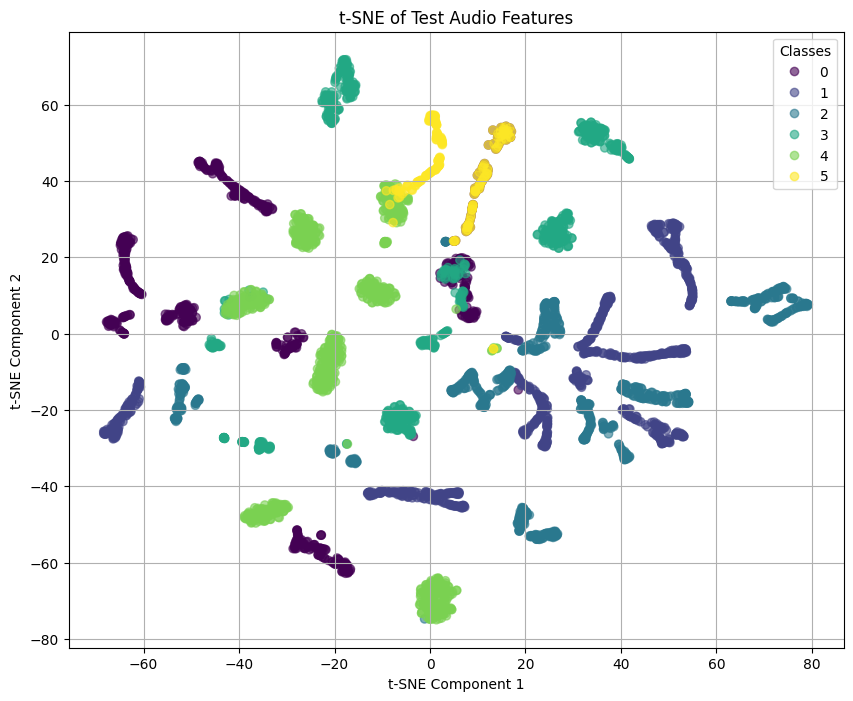

In [ ]:
# --------------------- t-SNE Process (Test Data) ---------------------
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print("Applying t-SNE to test data...")
# Use the same random_state as the training t-SNE for consistency if desired,
# but t-SNE is non-deterministic and results can vary.
tsne_test = TSNE(n_components=2, random_state=132)
X_test_embedded = tsne_test.fit_transform(X_train)

print("Plotting t-SNE results for test data...")
plt.figure(figsize=(10, 8))
scatter_test = plt.scatter(X_test_embedded[:, 0], X_test_embedded[:, 1], c=y_train, cmap='viridis', alpha=0.6)
plt.title('t-SNE of Test Audio Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
legend_test = plt.legend(*scatter_test.legend_elements(), title="Classes")
plt.grid(True)
plt.show()